## Reading in files

<span style="color:red">should possible utterencesbe the 5 intensifiers?</span>

<span style="color:red">Make sure to eliminate the ones who only choose endpoints</span>

Preprocessing data from csv

In [281]:
import pandas as pd
import matplotlib.pyplot as plt

# Read UK_df.csv as pandas dataframe
UK_dialogue = pd.read_csv('UK_df.csv')
UK_politeness = pd.read_csv('UK_direct_df.csv')
UK_narrator = pd.read_csv('UK_narrator_df.csv')
US_dialogue = pd.read_csv('US_df.csv')
US_politeness = pd.read_csv('US_direct_df.csv')
US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [UK_dialogue, UK_politeness, UK_narrator, US_dialogue, US_politeness, US_narrator]
def clean_data(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    end_prop = {}
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    # only keep columns with has_intensifier = yes
    df = df[df['has intensifier?'] == 'yes']
    return df[df['has intensifier?'] == 'yes']
for i in range(len(dataframes)):
    dataframes[i] = clean_data(dataframes[i])
print(dataframes[0]['has intensifier?'].value_counts())
politeness = pd.concat([dataframes[1], dataframes[4]])
narrator = pd.concat([dataframes[2], dataframes[5]])
dialogue = pd.concat([dataframes[0], dataframes[3]])

has intensifier?
yes    748
Name: count, dtype: int64


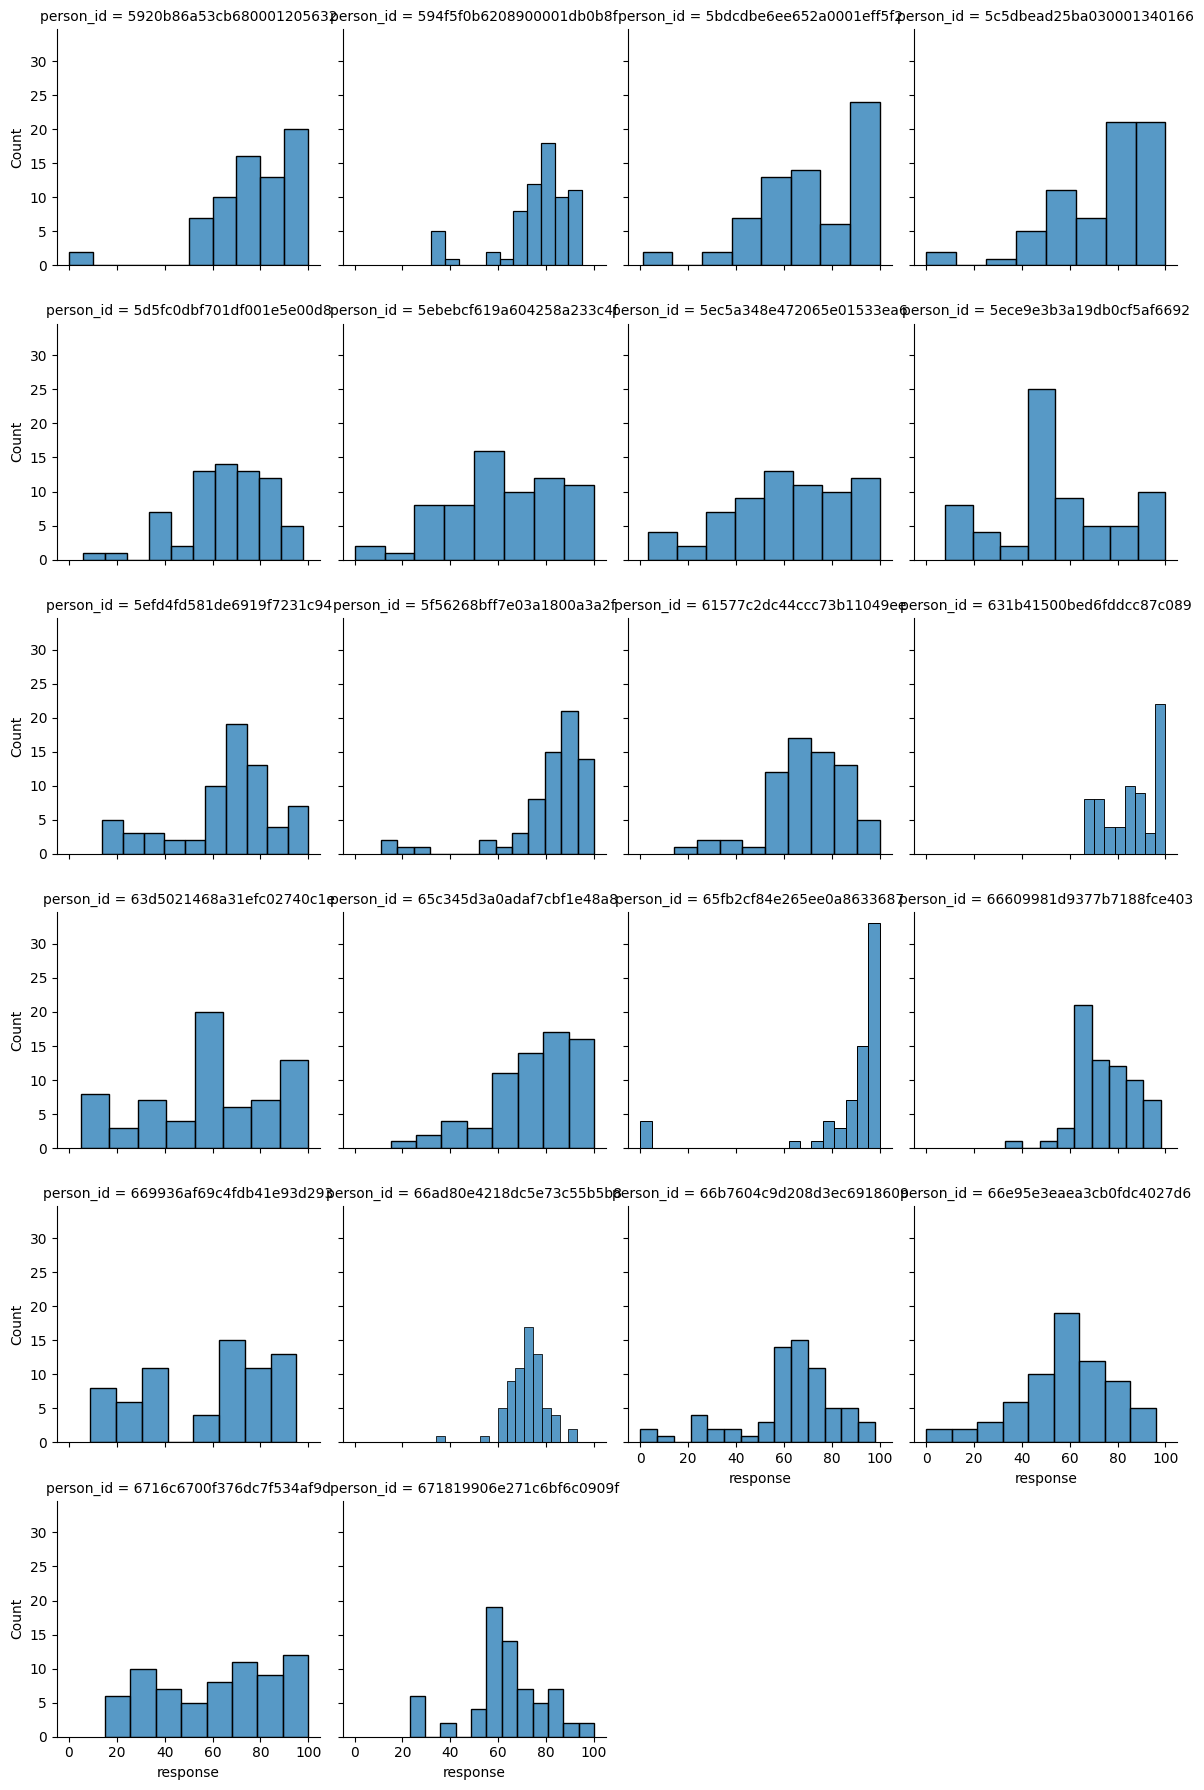

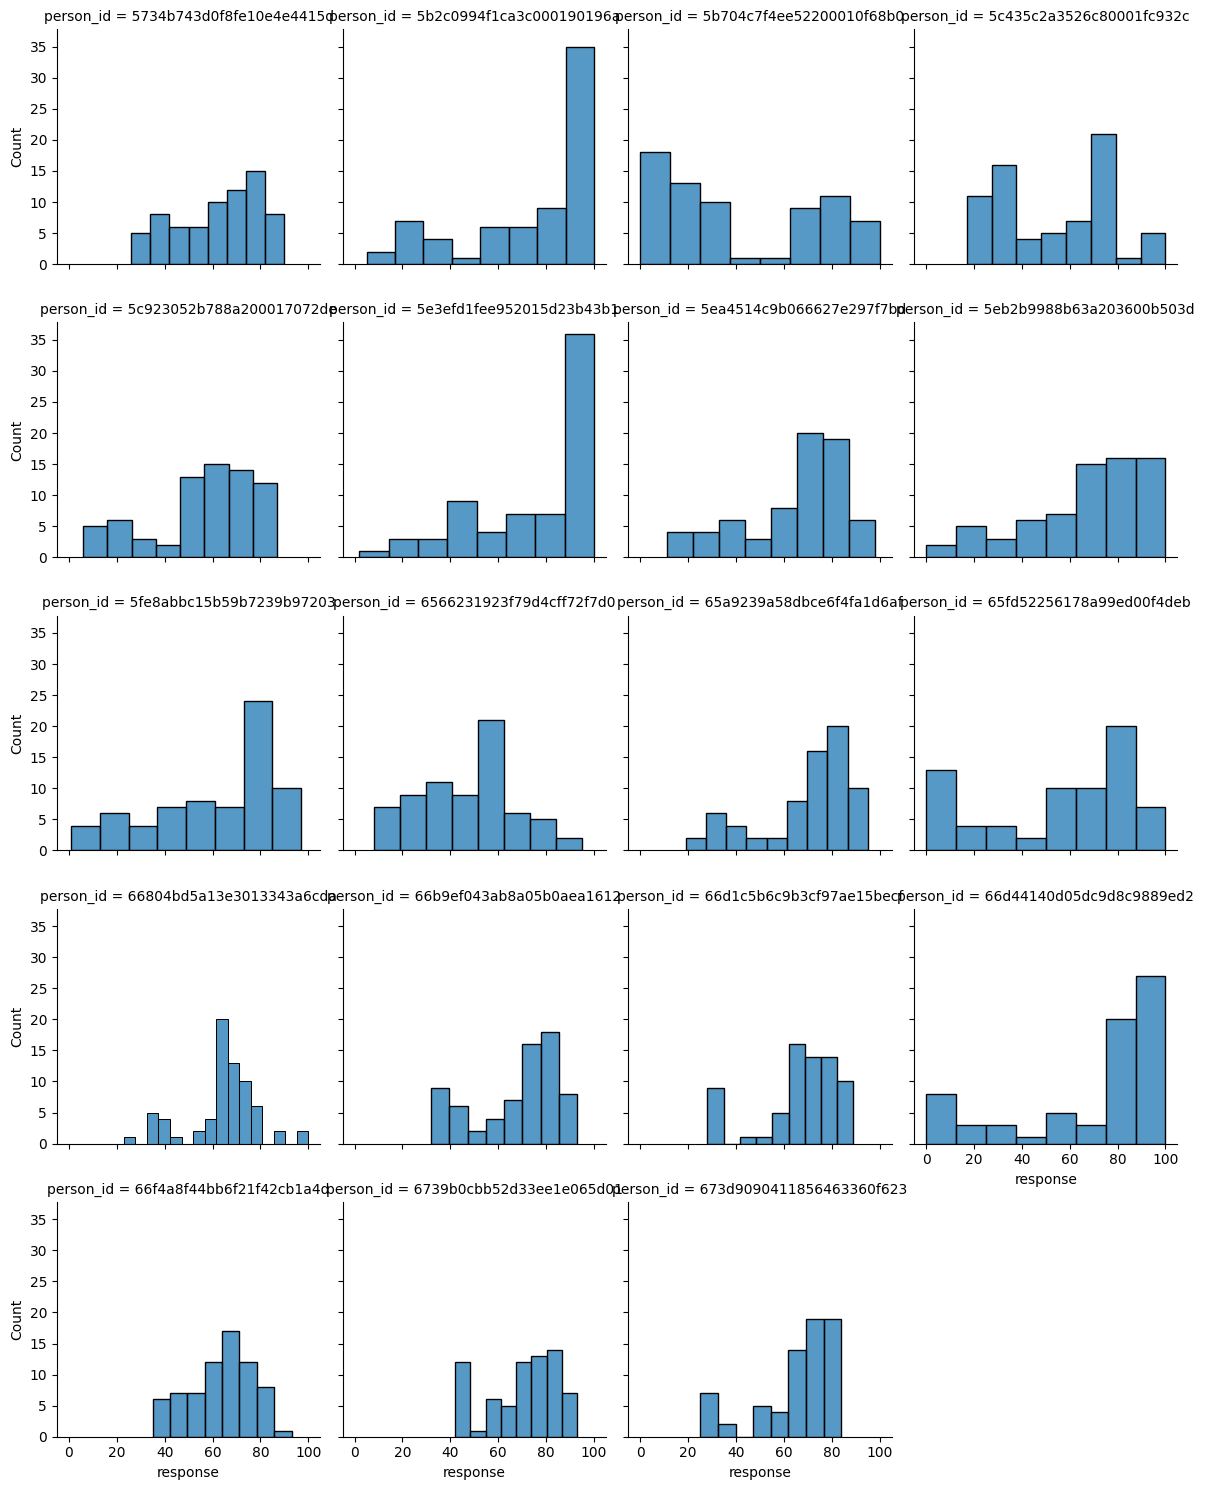

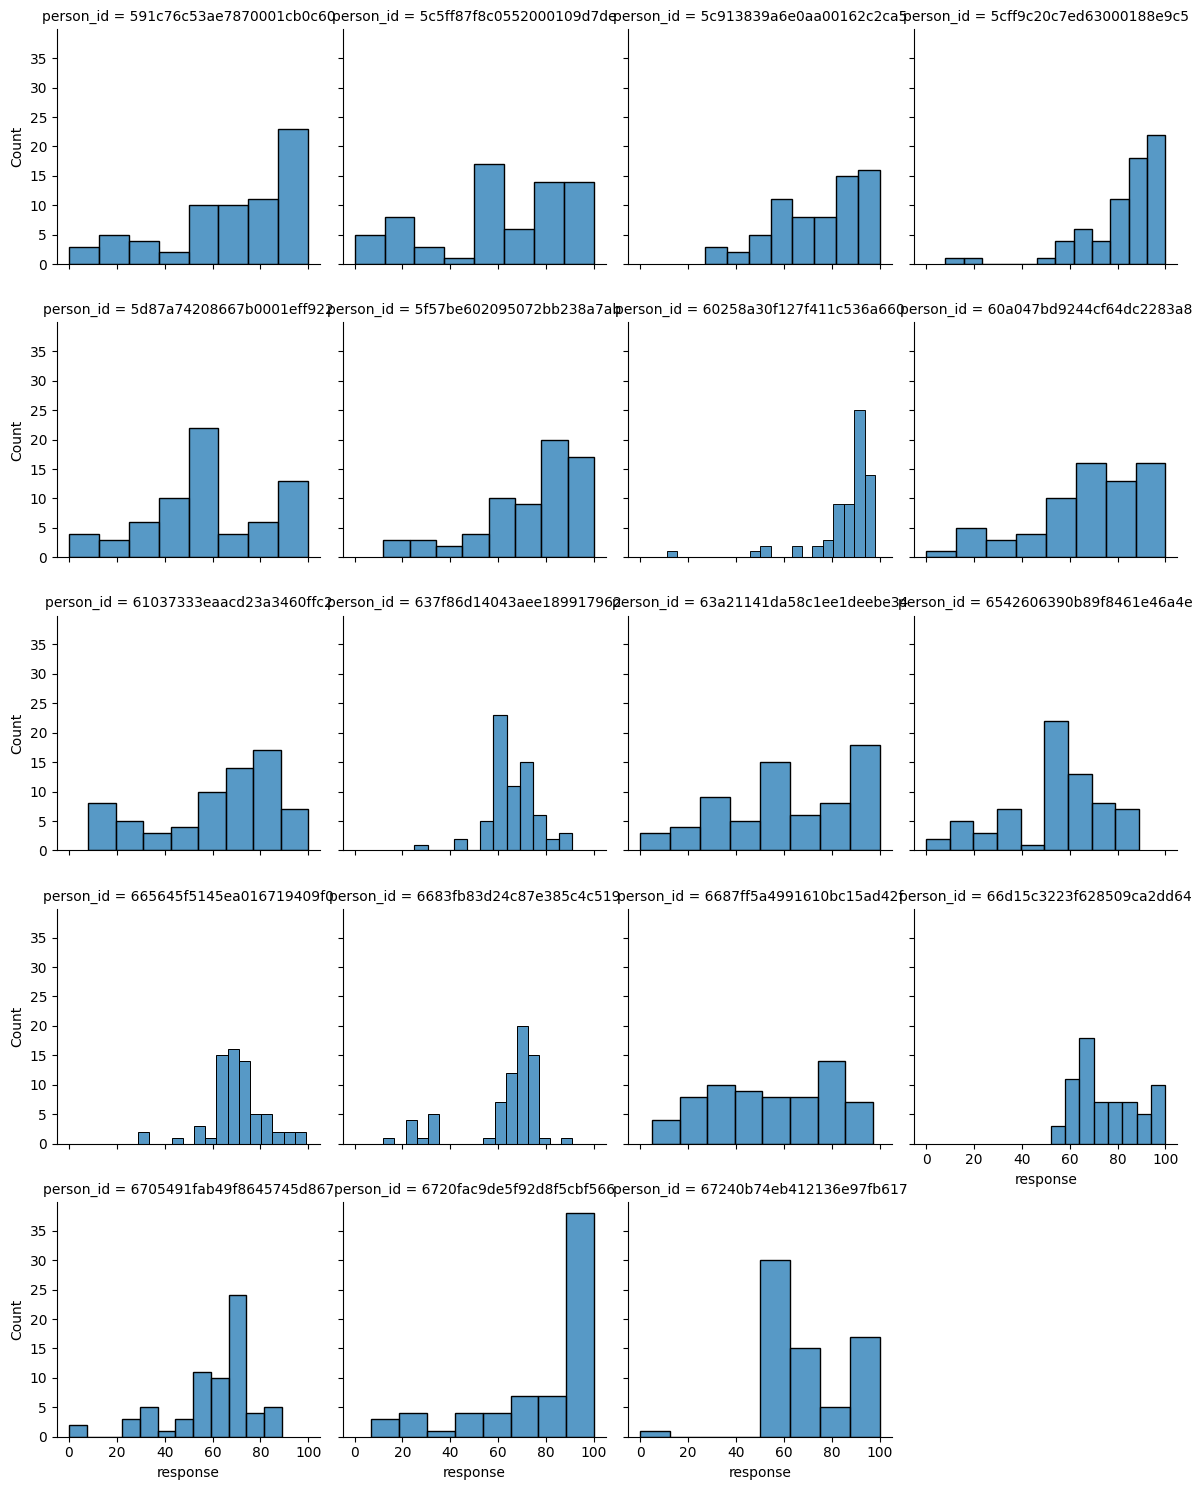

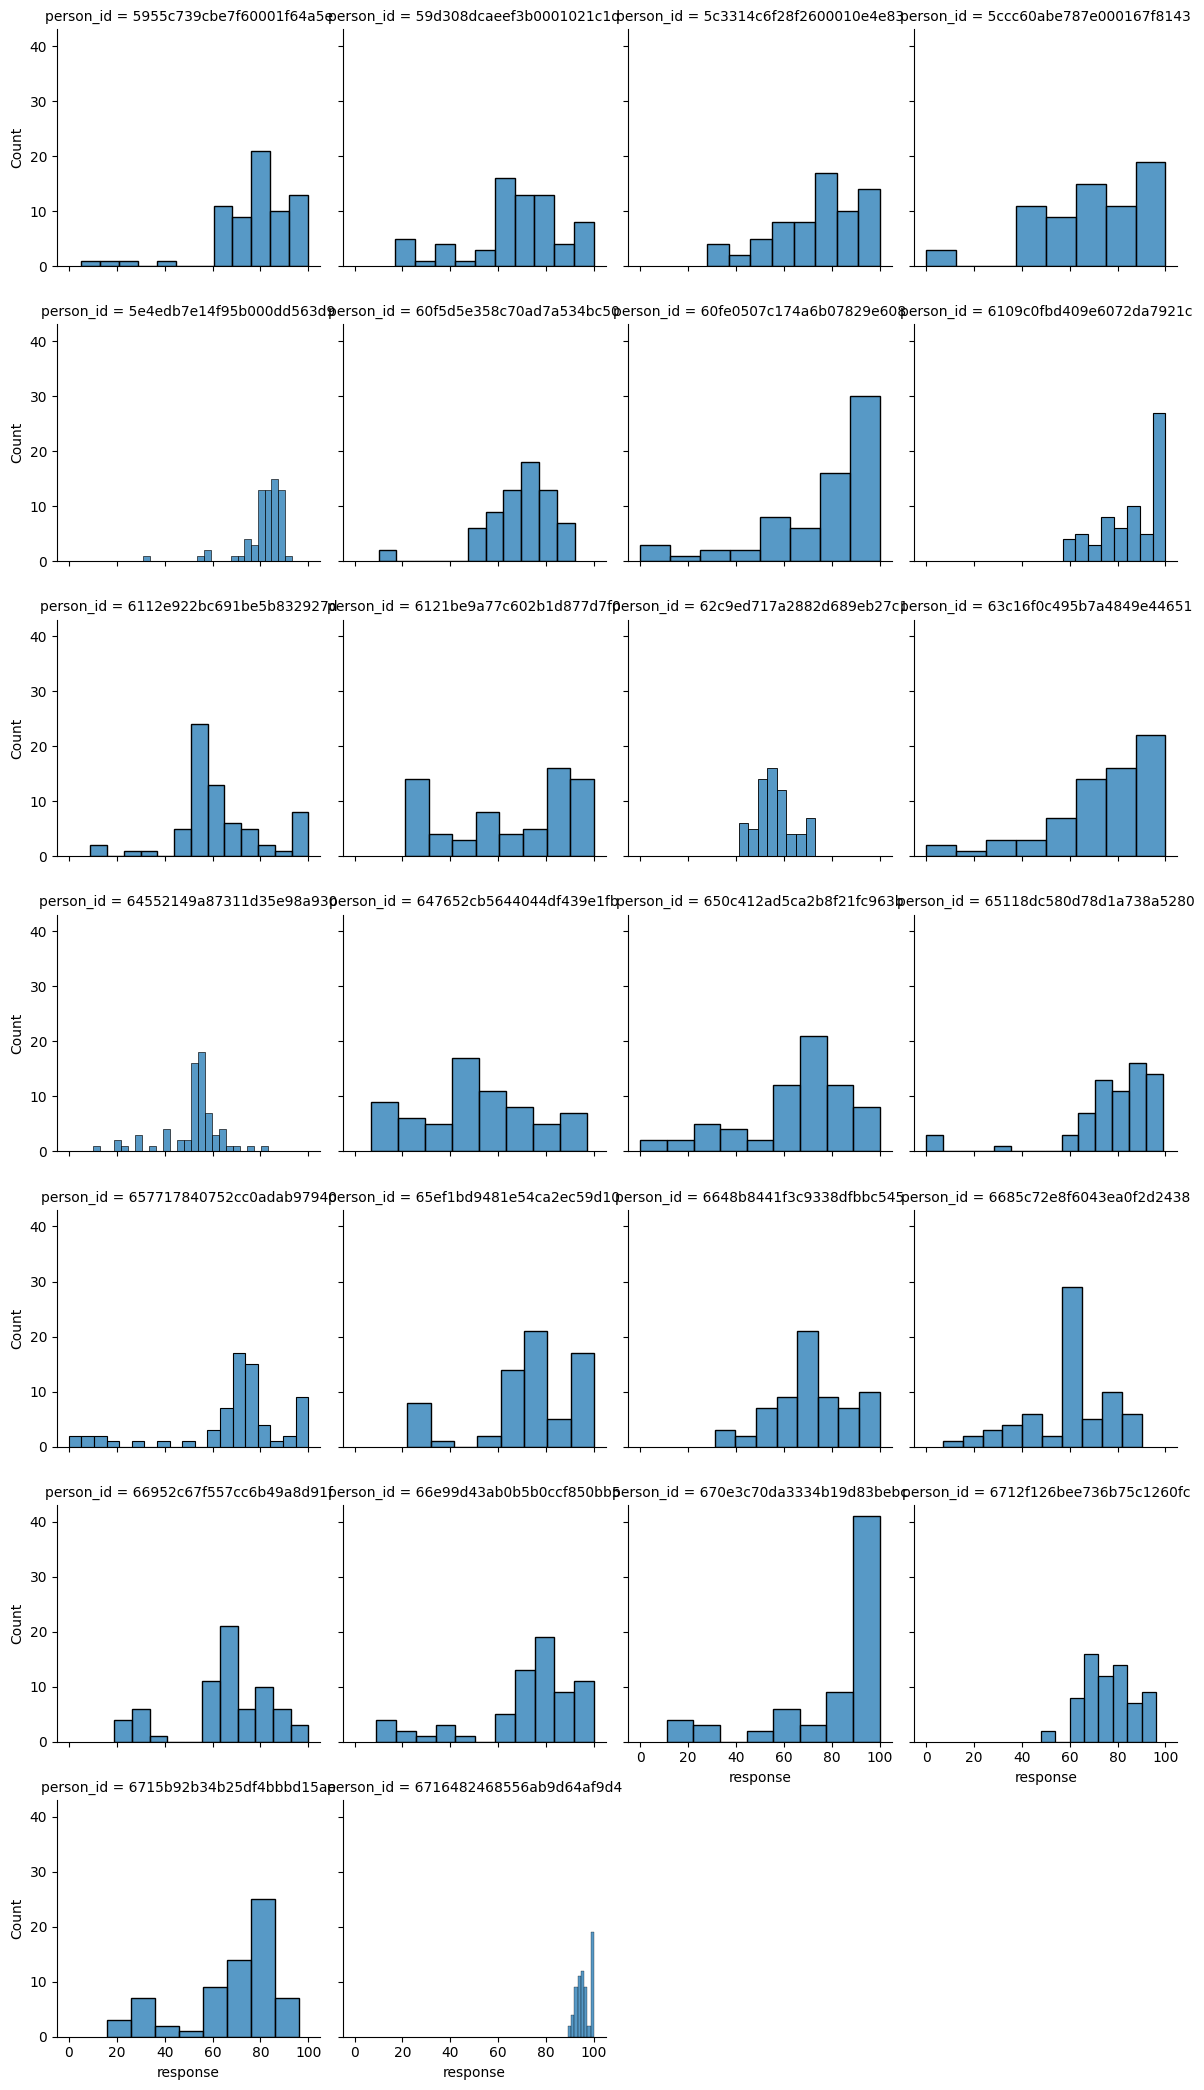

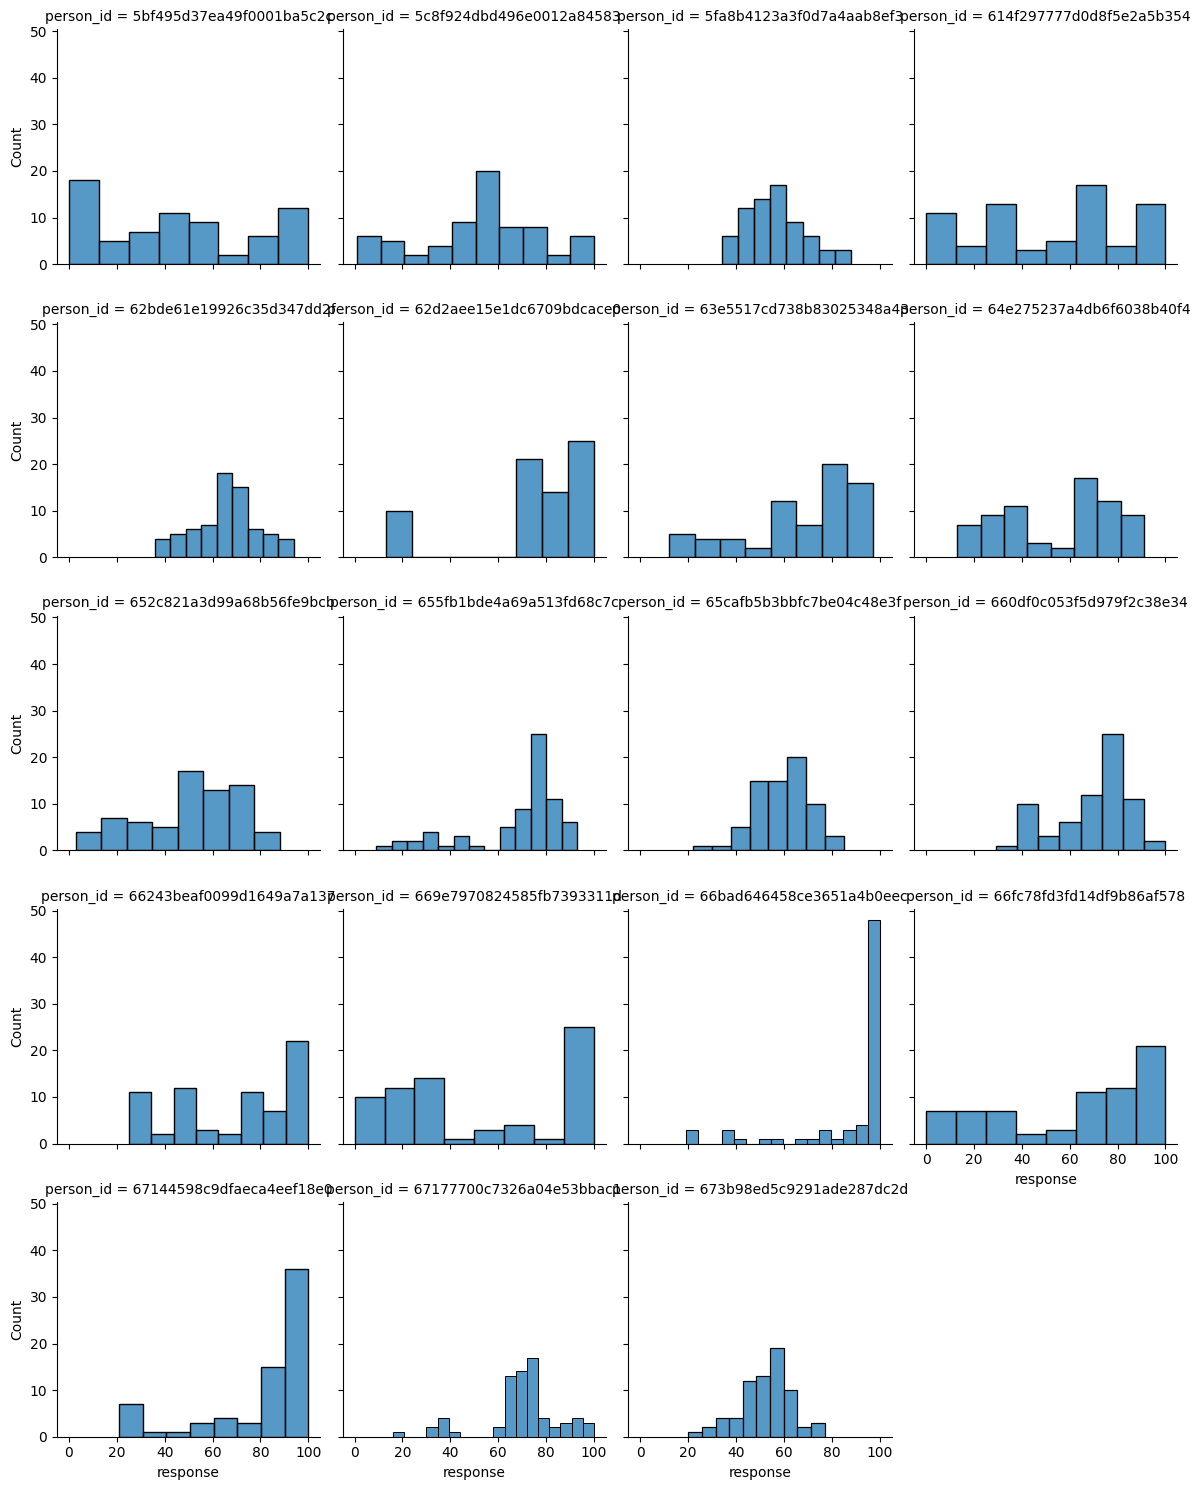

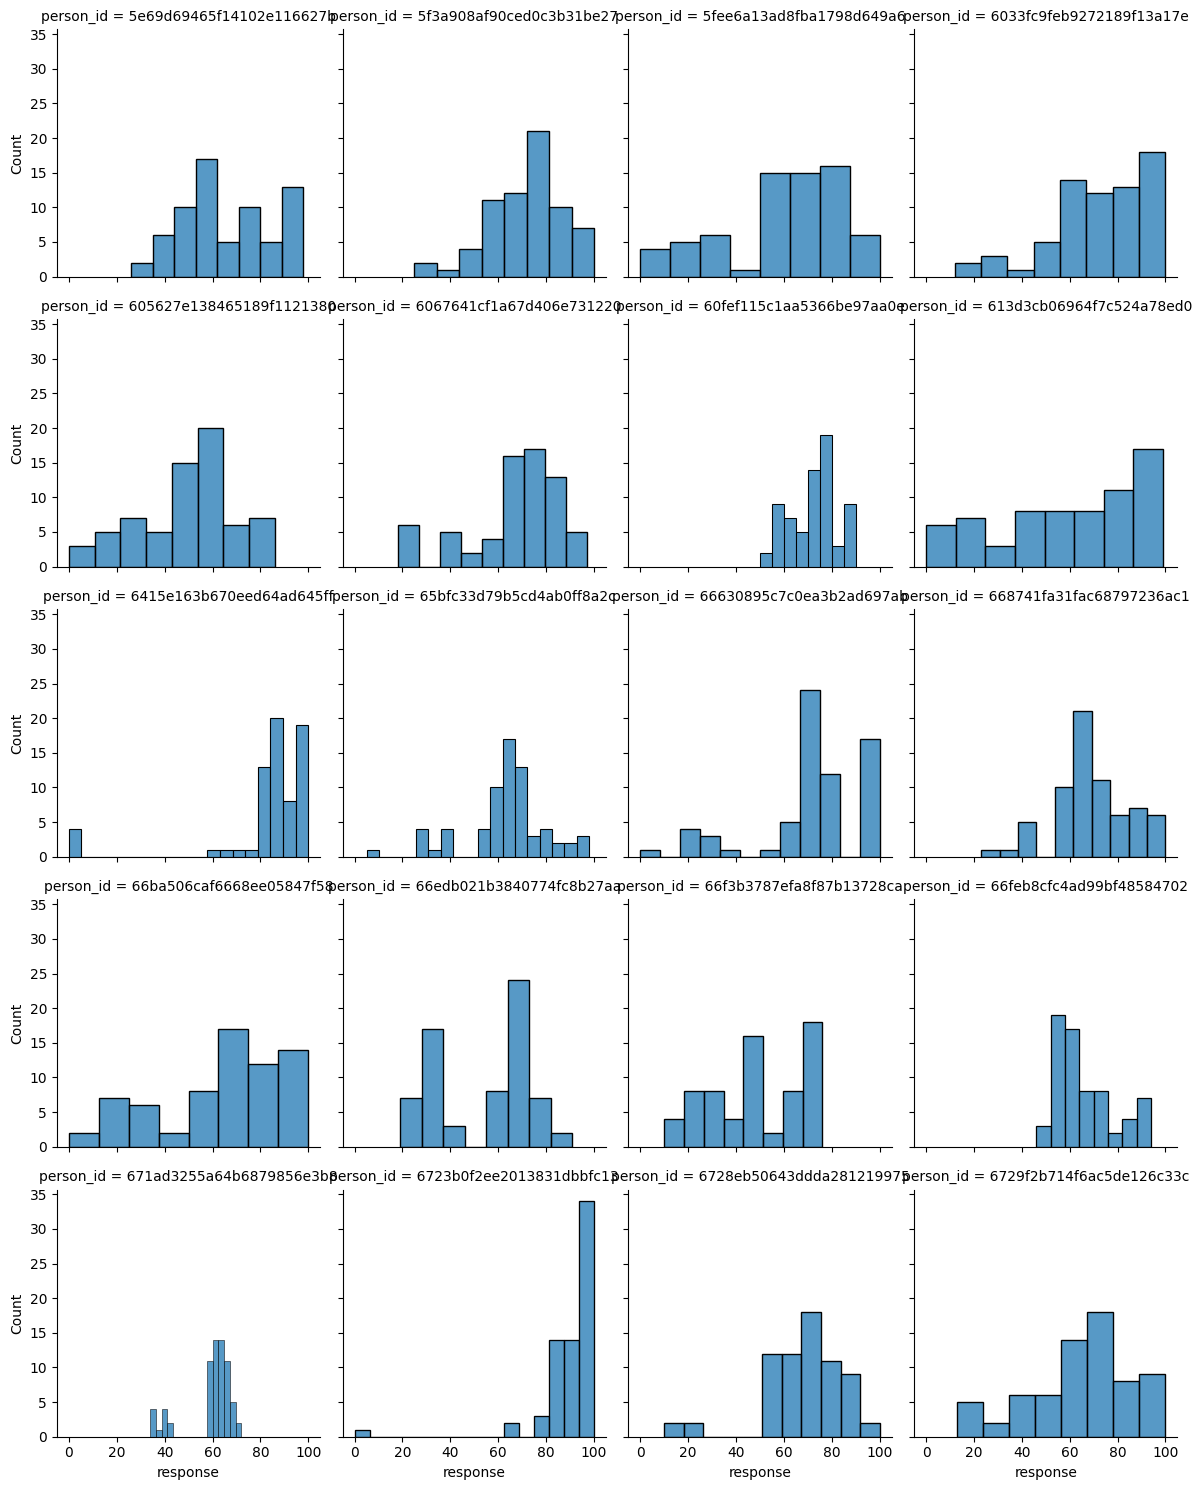

In [282]:
import seaborn as sns
for data in [UK_dialogue, UK_politeness, UK_narrator, US_dialogue, US_politeness, US_narrator]:
    sns.FacetGrid(data, col="person_id", col_wrap=4).map(sns.histplot, "response")

Compute U_soc from politeness data

In [246]:
# collapse rows with the same intensifier and predicate. Keep track of the mean of the std, difference, and Z_score difference
pol = politeness.groupby(['intensifier']).agg({ 'difference': 'mean', 'Z-Score Difference': 'mean'}).reset_index()
politeness.groupby(['intensifier','predicate']).agg({ 'difference': 'mean', 'Z-Score Difference': 'mean'}).reset_index()
# create key with intensifier and predicate as a tuple and value as Z-Score Difference
U_soc = politeness.set_index(['intensifier', 'predicate'])['Z-Score Difference'].to_dict()

In [247]:
# let states be an array of int from -100 to 100
states = list(range(-100, 101))

In [266]:
U_soc

{('slightly', 'exhausted'): 0.4821782853158233,
 ('kind of', 'exhausted'): 0.3857426282526587,
 ('quite', 'exhausted'): -1.2536635418211408,
 ('very', 'exhausted'): -0.4821782853158233,
 ('extremely', 'exhausted'): 0.0,
 ('slightly', 'boring'): -0.1928713141263293,
 ('kind of', 'boring'): -0.289306971189494,
 ('quite', 'boring'): -0.9643565706316468,
 ('very', 'boring'): -0.289306971189494,
 ('extremely', 'boring'): -1.157227884757976,
 ('slightly', 'difficult'): -0.0964356570631646,
 ('kind of', 'difficult'): 0.289306971189494,
 ('quite', 'difficult'): -0.0964356570631646,
 ('very', 'difficult'): 0.578613942378988,
 ('extremely', 'difficult'): 0.0964356570631646,
 ('slightly', 'concerned'): 0.1928713141263293,
 ('kind of', 'concerned'): -1.735841827136964,
 ('quite', 'concerned'): -0.7714852565053174,
 ('very', 'concerned'): -0.289306971189494,
 ('extremely', 'concerned'): 0.3857426282526587,
 ('slightly', 'understandable'): -0.1928713141263293,
 ('kind of', 'understandable'): -0.4821

Compute $P_{L_0}(state | utterance)$ (used kde to make plots smooth so no 0 probs)

In [248]:
# import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np
def softmax(x):
    # Subtract the max value from x for numerical stability
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

Make $U_{S_1}$ and compute $P_{S_1}$ thus $P_{L_1}$

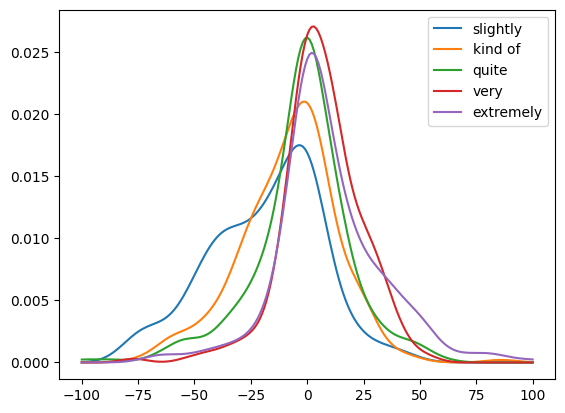

In [249]:
import numpy as np
utterences =list(U_soc.keys())
predicates = list(set(w[1] for w in utterences))
intensifiers = list(set(w[0] for w in utterences))
states = list(range(-100, 101))
U_inf = dict()
possible_phi = np.arange(0,1,0.1)
possible_alpha = np.arange(0,3,0.3)
for utterence in narrator['intensifier'].unique():
    data = narrator[narrator['intensifier'] == utterence]['difference']
    kde = gaussian_kde(data)
    densities_at_new_point = kde(states)  # This is the density at the new point
    # below is same as marginalizing so adds up to 1
    # plot kde as graph
    plt.plot(states, densities_at_new_point, label=utterence)
    U_inf[utterence] = np.log(densities_at_new_point)-np.log(np.sum(densities_at_new_point))
plt.legend()
def P_state(s):
    # prior over states, but subject to change
    return 101 - abs(s) # 101 instead of 100 to avoid 0
def U_s1(w,s,phi):
    # corresponds to U_s1(w) in the paper
    return phi*U_soc[w] + (1-phi)*U_inf[w[0]][s+100]
# s spans from -100 to 100
P_s1 = dict() # corresponds to P_S1(w|s,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for s in states:
            # marginalized over all utterences with same predicate ('slightly' 'kind of' 'quite' 'very' 'extremely')
            for pred in predicates:
                P_s1[(alpha,phi,s,pred)] = softmax([ alpha*U_s1((w,pred),s,phi) for w in intensifiers])
# only thing left is computing P_l1
P_l1 = dict()# corresponds to P_L1(s|w,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for i in range(len(intensifiers)):
            for pred in predicates:
                w = intensifiers[i]
                P_l1[(alpha,phi,(w,pred))] = [P_s1[(alpha,phi,s,pred)][i]*P_state(s) for s in states]
                # normalize so adds up to 1
                P_l1[(alpha,phi,(w,pred))] = P_l1[(alpha,phi,(w,pred))]/np.sum(P_l1[(alpha,phi,(w,pred))])

## Test fit with data

In [250]:
def test_fit(data,P_l1):
    # test fit of model, P_l1 with data
    fit_judgement=dict()    
    for w in utterences:
        fit_judgement[w] = np.zeros((len(possible_phi),len(possible_alpha)))
        measured_values = data[((data['intensifier'] == w[0]) & (data['predicate'] == w[1]))]['difference'].values
        for i in range(len(possible_phi)):
            for j in range(len(possible_alpha)):
                fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int(s)+100]) for s in measured_values)
    return fit_judgement
fit_judgement = test_fit(dialogue,P_l1)
UK_fit_judgement = test_fit(dataframes[0],P_l1)
US_fit_judgement = test_fit(dataframes[3],P_l1)

C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\1977602079.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int(s)+100]) for s in measured_values)


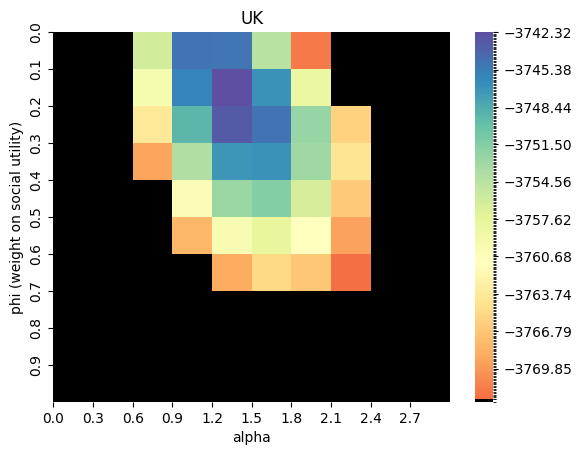

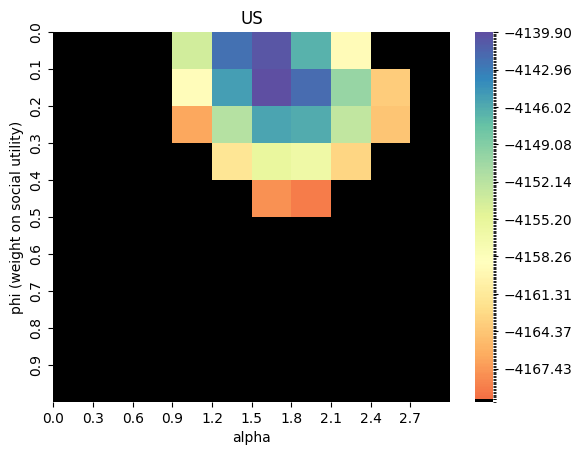

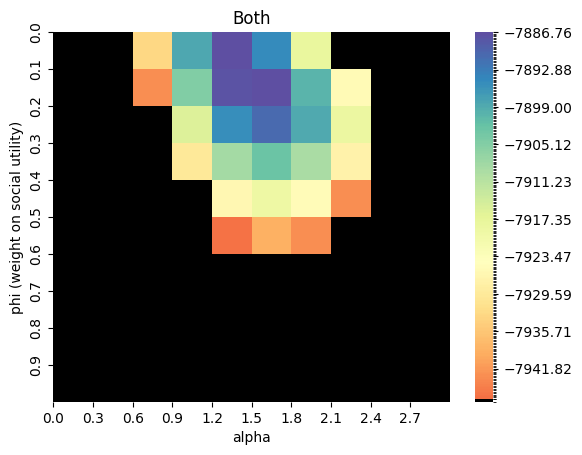

US best fit: (1, 5)
UK best fit: (1, 4)
best fit: (1, 5)


In [252]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
# Define a custom colormap
base_cmap = sns.color_palette("Spectral", as_cmap=True)  # Base colormap
colors = ["black"] + list(base_cmap(np.linspace(0.2, 1, 256)))  # Add black for below threshold
custom_cmap = ListedColormap(colors)

def plot_fits(fit_judgement, possible_alpha, possible_phi,title,minus_thresh):
    # Define a normalization function
    threshold = np.max(np.sum([fit_judgement[w] for w in utterences],axis=0))+minus_thresh
    bounds = [-10000, threshold] + list(np.linspace(threshold, np.max(np.sum([fit_judgement[w] for w in utterences],axis=0)), 256))
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    sns.heatmap(np.sum([fit_judgement[w] for w in utterences],axis=0), cmap=custom_cmap, norm=norm, cbar=True)# label x and y by the possible values
    plt.xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
    plt.yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
    # label x and y axis
    plt.xlabel('alpha')
    plt.ylabel('phi (weight on social utility)')
    # label colors in heatmap
    plt.title(title)
    # plt.colorbar()
    plt.show()
plot_fits(UK_fit_judgement,possible_alpha,possible_phi,'UK',-30)
plot_fits(US_fit_judgement,possible_alpha,possible_phi,'US',-30)
# plot both
plot_fits(fit_judgement,possible_alpha,possible_phi,'Both',-60)
# print best fit for US and UK
print(f"US best fit: {np.unravel_index(np.argmax(np.sum([US_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([fit_judgement[w] for w in utterences],axis=0).shape)}")
print(f"UK best fit: {np.unravel_index(np.argmax(np.sum([UK_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([fit_judgement[w] for w in utterences],axis=0).shape)}")
print(f"best fit: {np.unravel_index(np.argmax(np.sum([fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([fit_judgement[w] for w in utterences],axis=0).shape)}")

## Do the same thing but using Z-Score Difference as the state values

very 0.31508649534802086
slightly -0.8476396444174623
extremely 0.423307572687601
quite -0.1434112423146401
kind of -0.34639293611900196


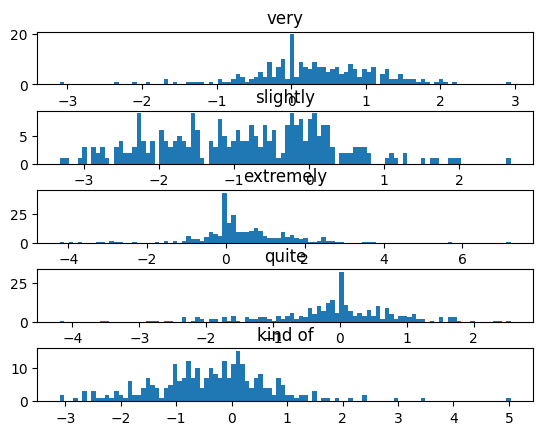

In [267]:
# plot frequency of values in narrator[narrator['intensifier'] == 'very']['Z-Score Difference'].values
for i in range(len(intensifiers)):
    plt.subplot(5, 1, i+1)
    # give more space between subplots
    plt.subplots_adjust(hspace=0.5)
    plt.hist(narrator[narrator['intensifier'] == intensifiers[i]]['Z-Score Difference'].values, bins=100)
    print(intensifiers[i],np.mean(narrator[narrator['intensifier'] == intensifiers[i]]['Z-Score Difference'].values))
    plt.title(intensifiers[i])


implementing computational model

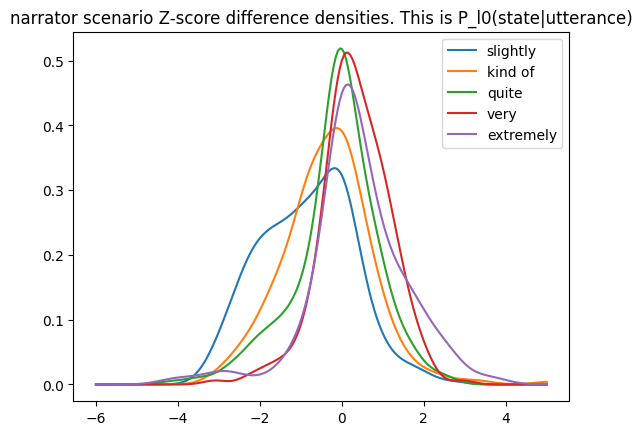

In [ ]:
import numpy as np
utterences =list(U_soc.keys())
predicates = list(set(w[1] for w in utterences))
intensifiers = list(set(w[0] for w in utterences))
# states are -3 to 3 with step size of 0.05
states = np.arange(-6, 5.05, 0.05)
new_U_inf = dict()
possible_phi = np.arange(0,1,0.05)
possible_alpha = np.arange(0,3,0.15)
for utterence in narrator['intensifier'].unique():
    data = narrator[narrator['intensifier'] == utterence]['Z-Score Difference']
    kde = gaussian_kde(data)
    densities_at_new_point = kde(states)  # This is the density at the new point
    # below is same as marginalizing so adds up to 1
    # plot kde as graph
    
    plt.plot(states, densities_at_new_point, label=utterence)
    # plot barplot of data
    new_U_inf[utterence] = np.log(densities_at_new_point)-np.log(np.sum(densities_at_new_point))
plt.legend()
plt.title('narrator scenario Z-score difference densities. This is P_l0(state|utterance)')
def new_P_state(s):
    # prior over states, but subject to change
    # return a gaussian with mean 0 std 1
    return (1/np.sqrt(2*np.pi))*np.exp(-((s-0)**2)/(2*1**2))
def new_U_s1(w,s,phi):
    # corresponds to U_s1(w) in the paper
    return phi*U_soc[w] + (1-phi)*new_U_inf[w[0]][int(s*20)+120]
# s spans from -100 to 100
new_P_s1 = dict() # corresponds to P_S1(w|s,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for s in states:
            # marginalized over all utterences with same predicate ('slightly' 'kind of' 'quite' 'very' 'extremely')
            for pred in predicates:
                new_P_s1[(alpha,phi,s,pred)] = softmax([ alpha*new_U_s1((w,pred),s,phi) for w in intensifiers])
# only thing left is computing P_l1
new_P_l1 = dict()# corresponds to P_L1(s|w,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for i in range(len(intensifiers)):
            for pred in predicates:
                w = intensifiers[i]
                new_P_l1[(alpha,phi,(w,pred))] = [new_P_s1[(alpha,phi,s,pred)][i]*new_P_state(s) for s in states]
                # normalize so adds up to 1
                new_P_l1[(alpha,phi,(w,pred))] = new_P_l1[(alpha,phi,(w,pred))]/np.sum(new_P_l1[(alpha,phi,(w,pred))])

C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\3635587199.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int(s*20)+120]) for s in measured_values)


person_id             5e4edb7e14f95b000dd563d9
country                                     US
intensifier                           slightly
predicate                           impressive
response                                    31
rt                                       11874
has intensifier?                           yes
difference                               -53.0
Z-Score                              -5.355893
std                                   9.454712
Z-Score Difference                   -5.605671
scenario_type                         dialogue
scenario_country                   dialogue US
Name: 322, dtype: object 27


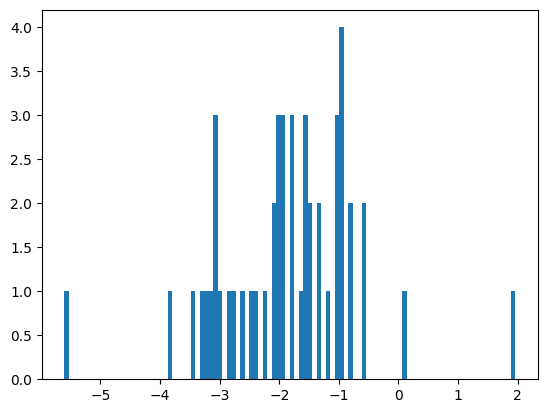

-29.48545864352446
person_id             5e4edb7e14f95b000dd563d9
country                                     US
intensifier                           slightly
predicate                           impressive
response                                    31
rt                                       11874
has intensifier?                           yes
difference                               -53.0
Z-Score                              -5.355893
std                                   9.454712
Z-Score Difference                   -5.605671
scenario_type                         dialogue
scenario_country                   dialogue US
Name: 322, dtype: object 4


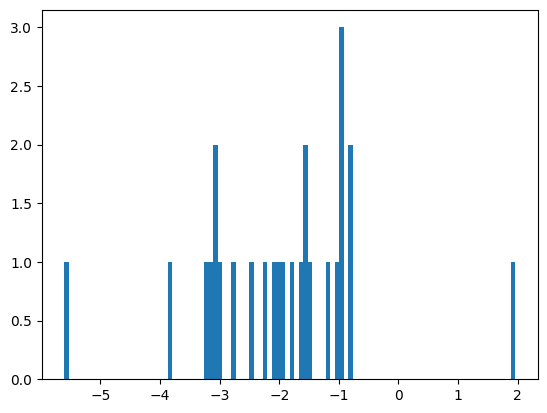

-29.48545864352446


In [255]:
def new_test_fit(data,P_l1):
    # test fit of model, P_l1 with data
    fit_judgement=dict()    
    for w in utterences:
        fit_judgement[w] = np.zeros((len(possible_phi),len(possible_alpha)))
        measured_values = data[((data['intensifier'] == w[0]) & (data['predicate'] == w[1]))]['Z-Score Difference'].values
        # print minimum of measured values
        if measured_values.size> 0:

            if np.min(measured_values) < -5:
                # get min value index
                min_index = np.argmin(measured_values)
                print(data[((data['intensifier'] == w[0]) & (data['predicate'] == w[1]))].iloc[min_index],min_index)
                plt.hist(measured_values, bins=100)
                plt.show()
                print(np.log(P_l1[(possible_alpha[7],0.2,w)][int(measured_values[min_index]*20)+120]))
            if np.max(measured_values) > 5:
                print(np.max(measured_values))
        for i in range(len(possible_phi)):
            for j in range(len(possible_alpha)):
                fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int(s*20)+120]) for s in measured_values)
    return fit_judgement
new_fit_judgement = new_test_fit(dialogue,new_P_l1)
new_UK_fit_judgement = new_test_fit(dataframes[0],new_P_l1)
new_US_fit_judgement = new_test_fit(dataframes[3],new_P_l1)

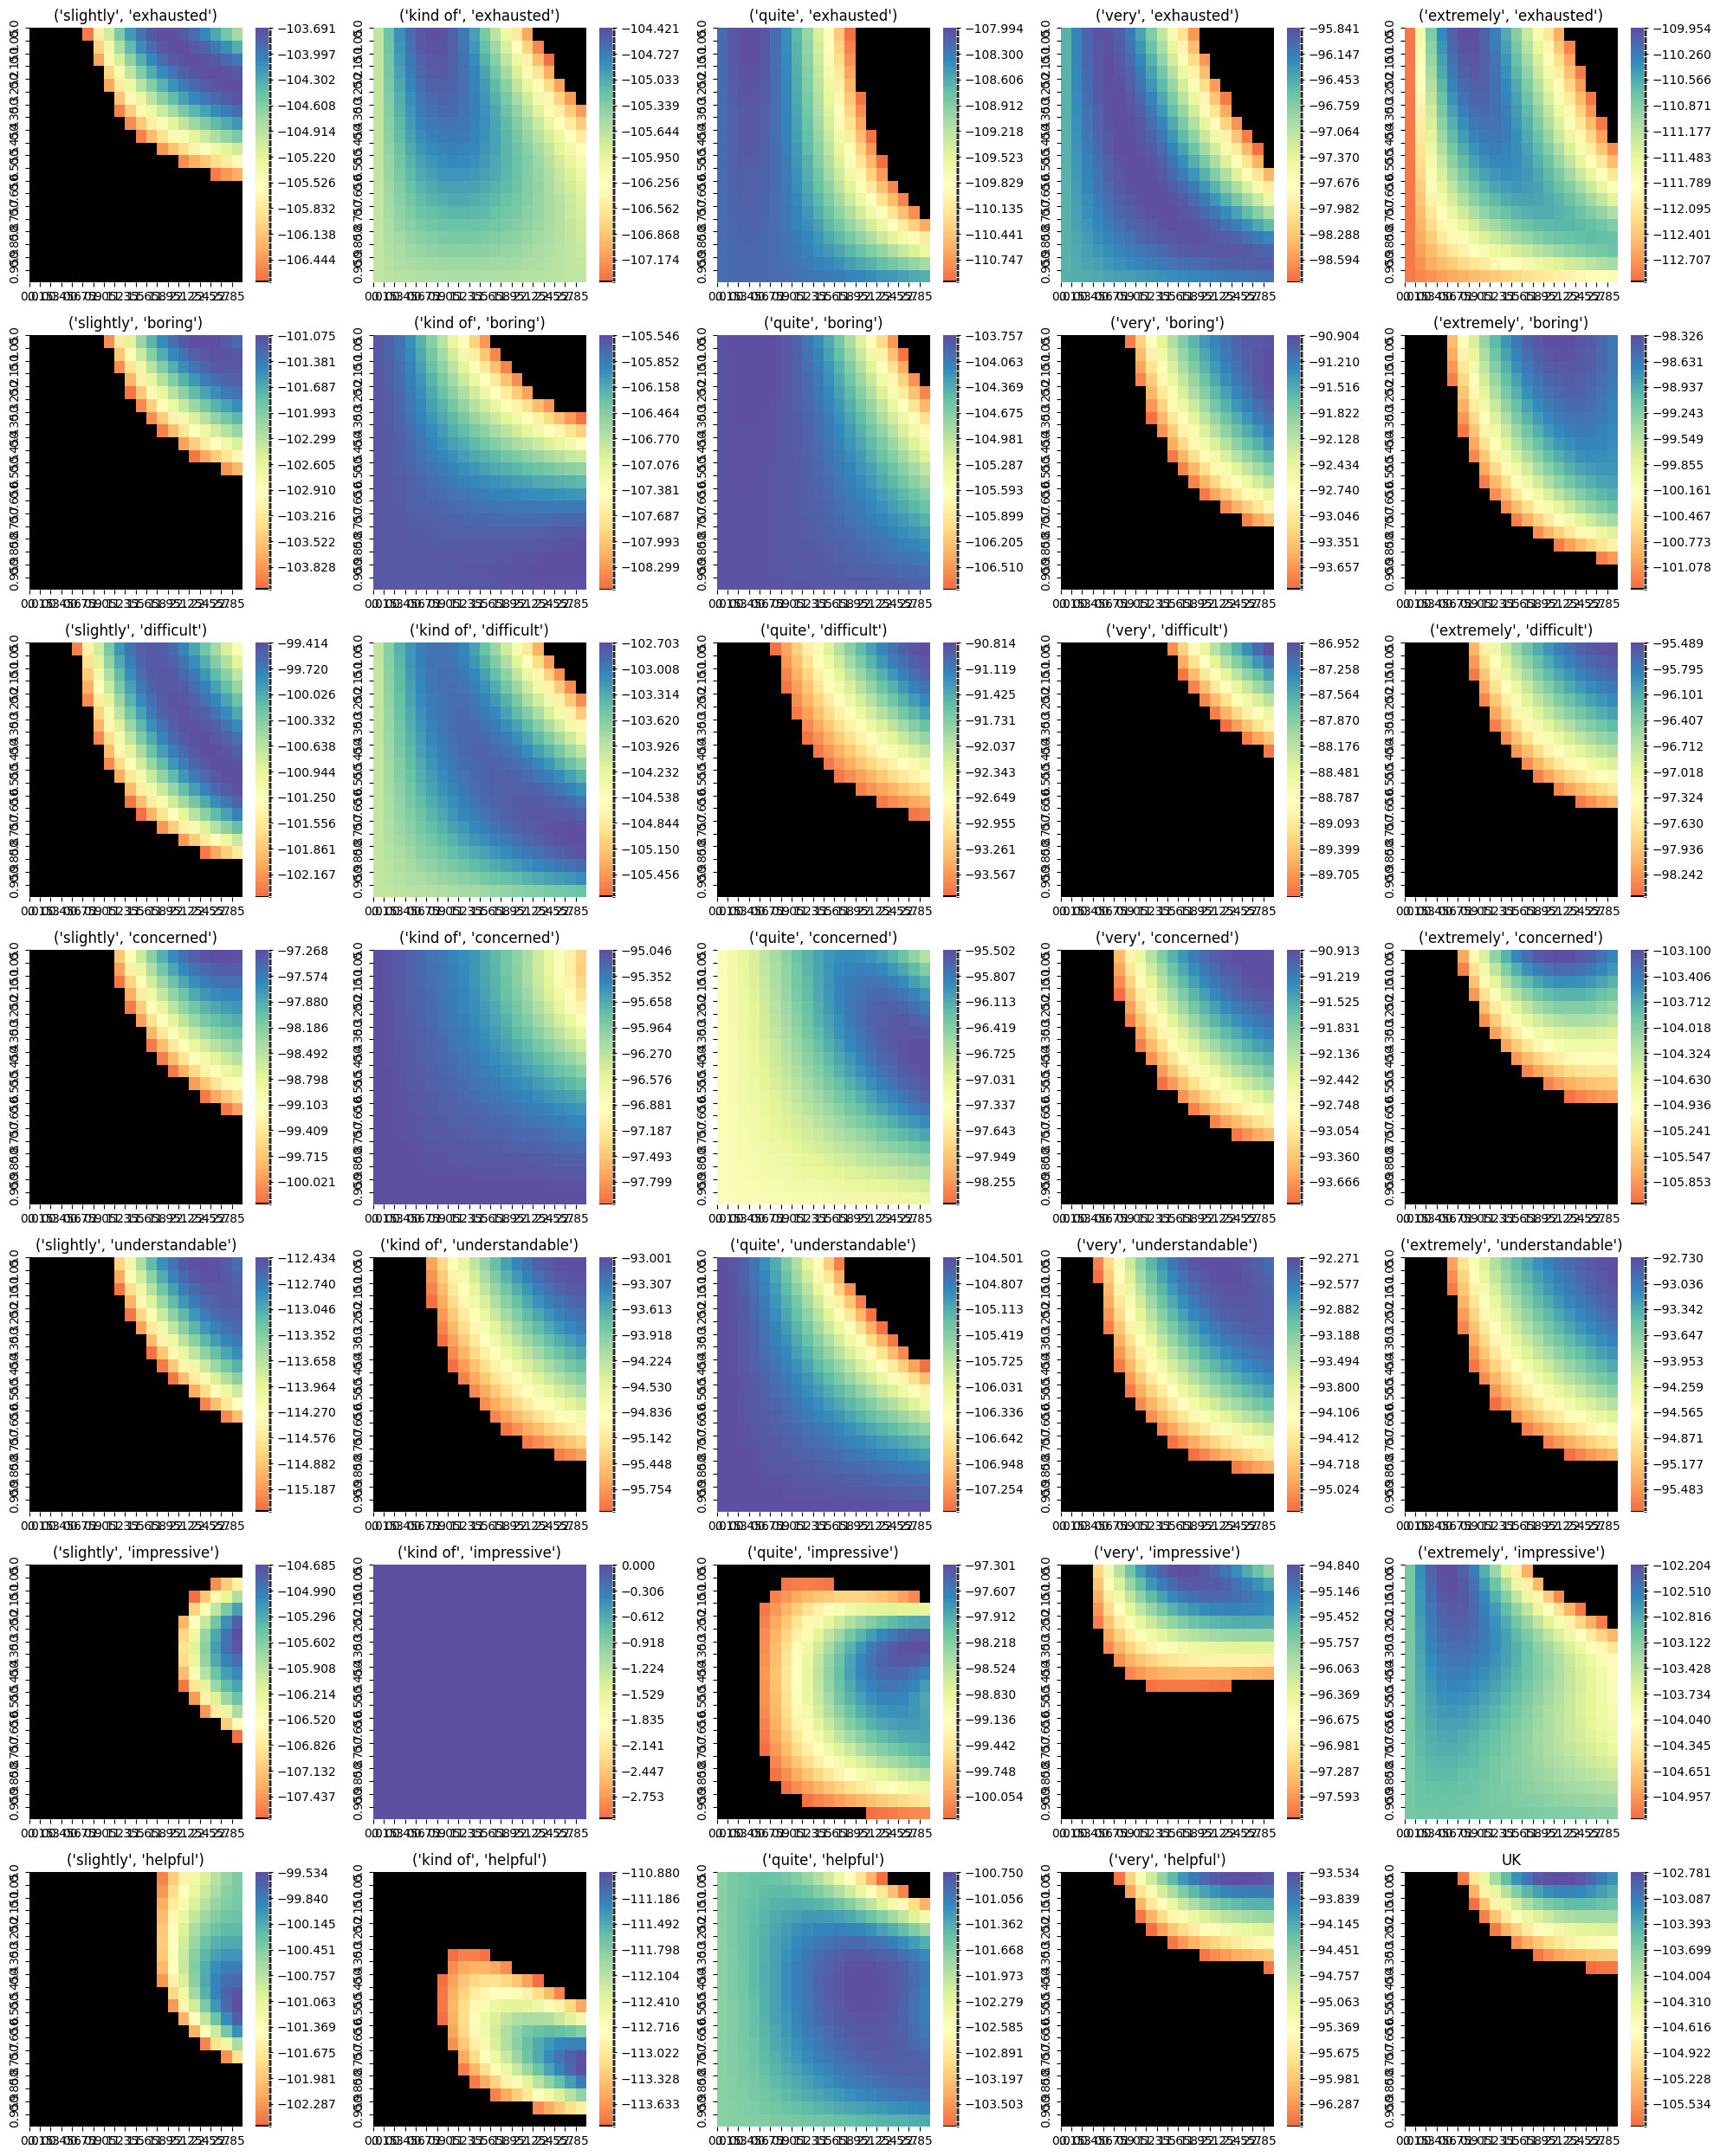

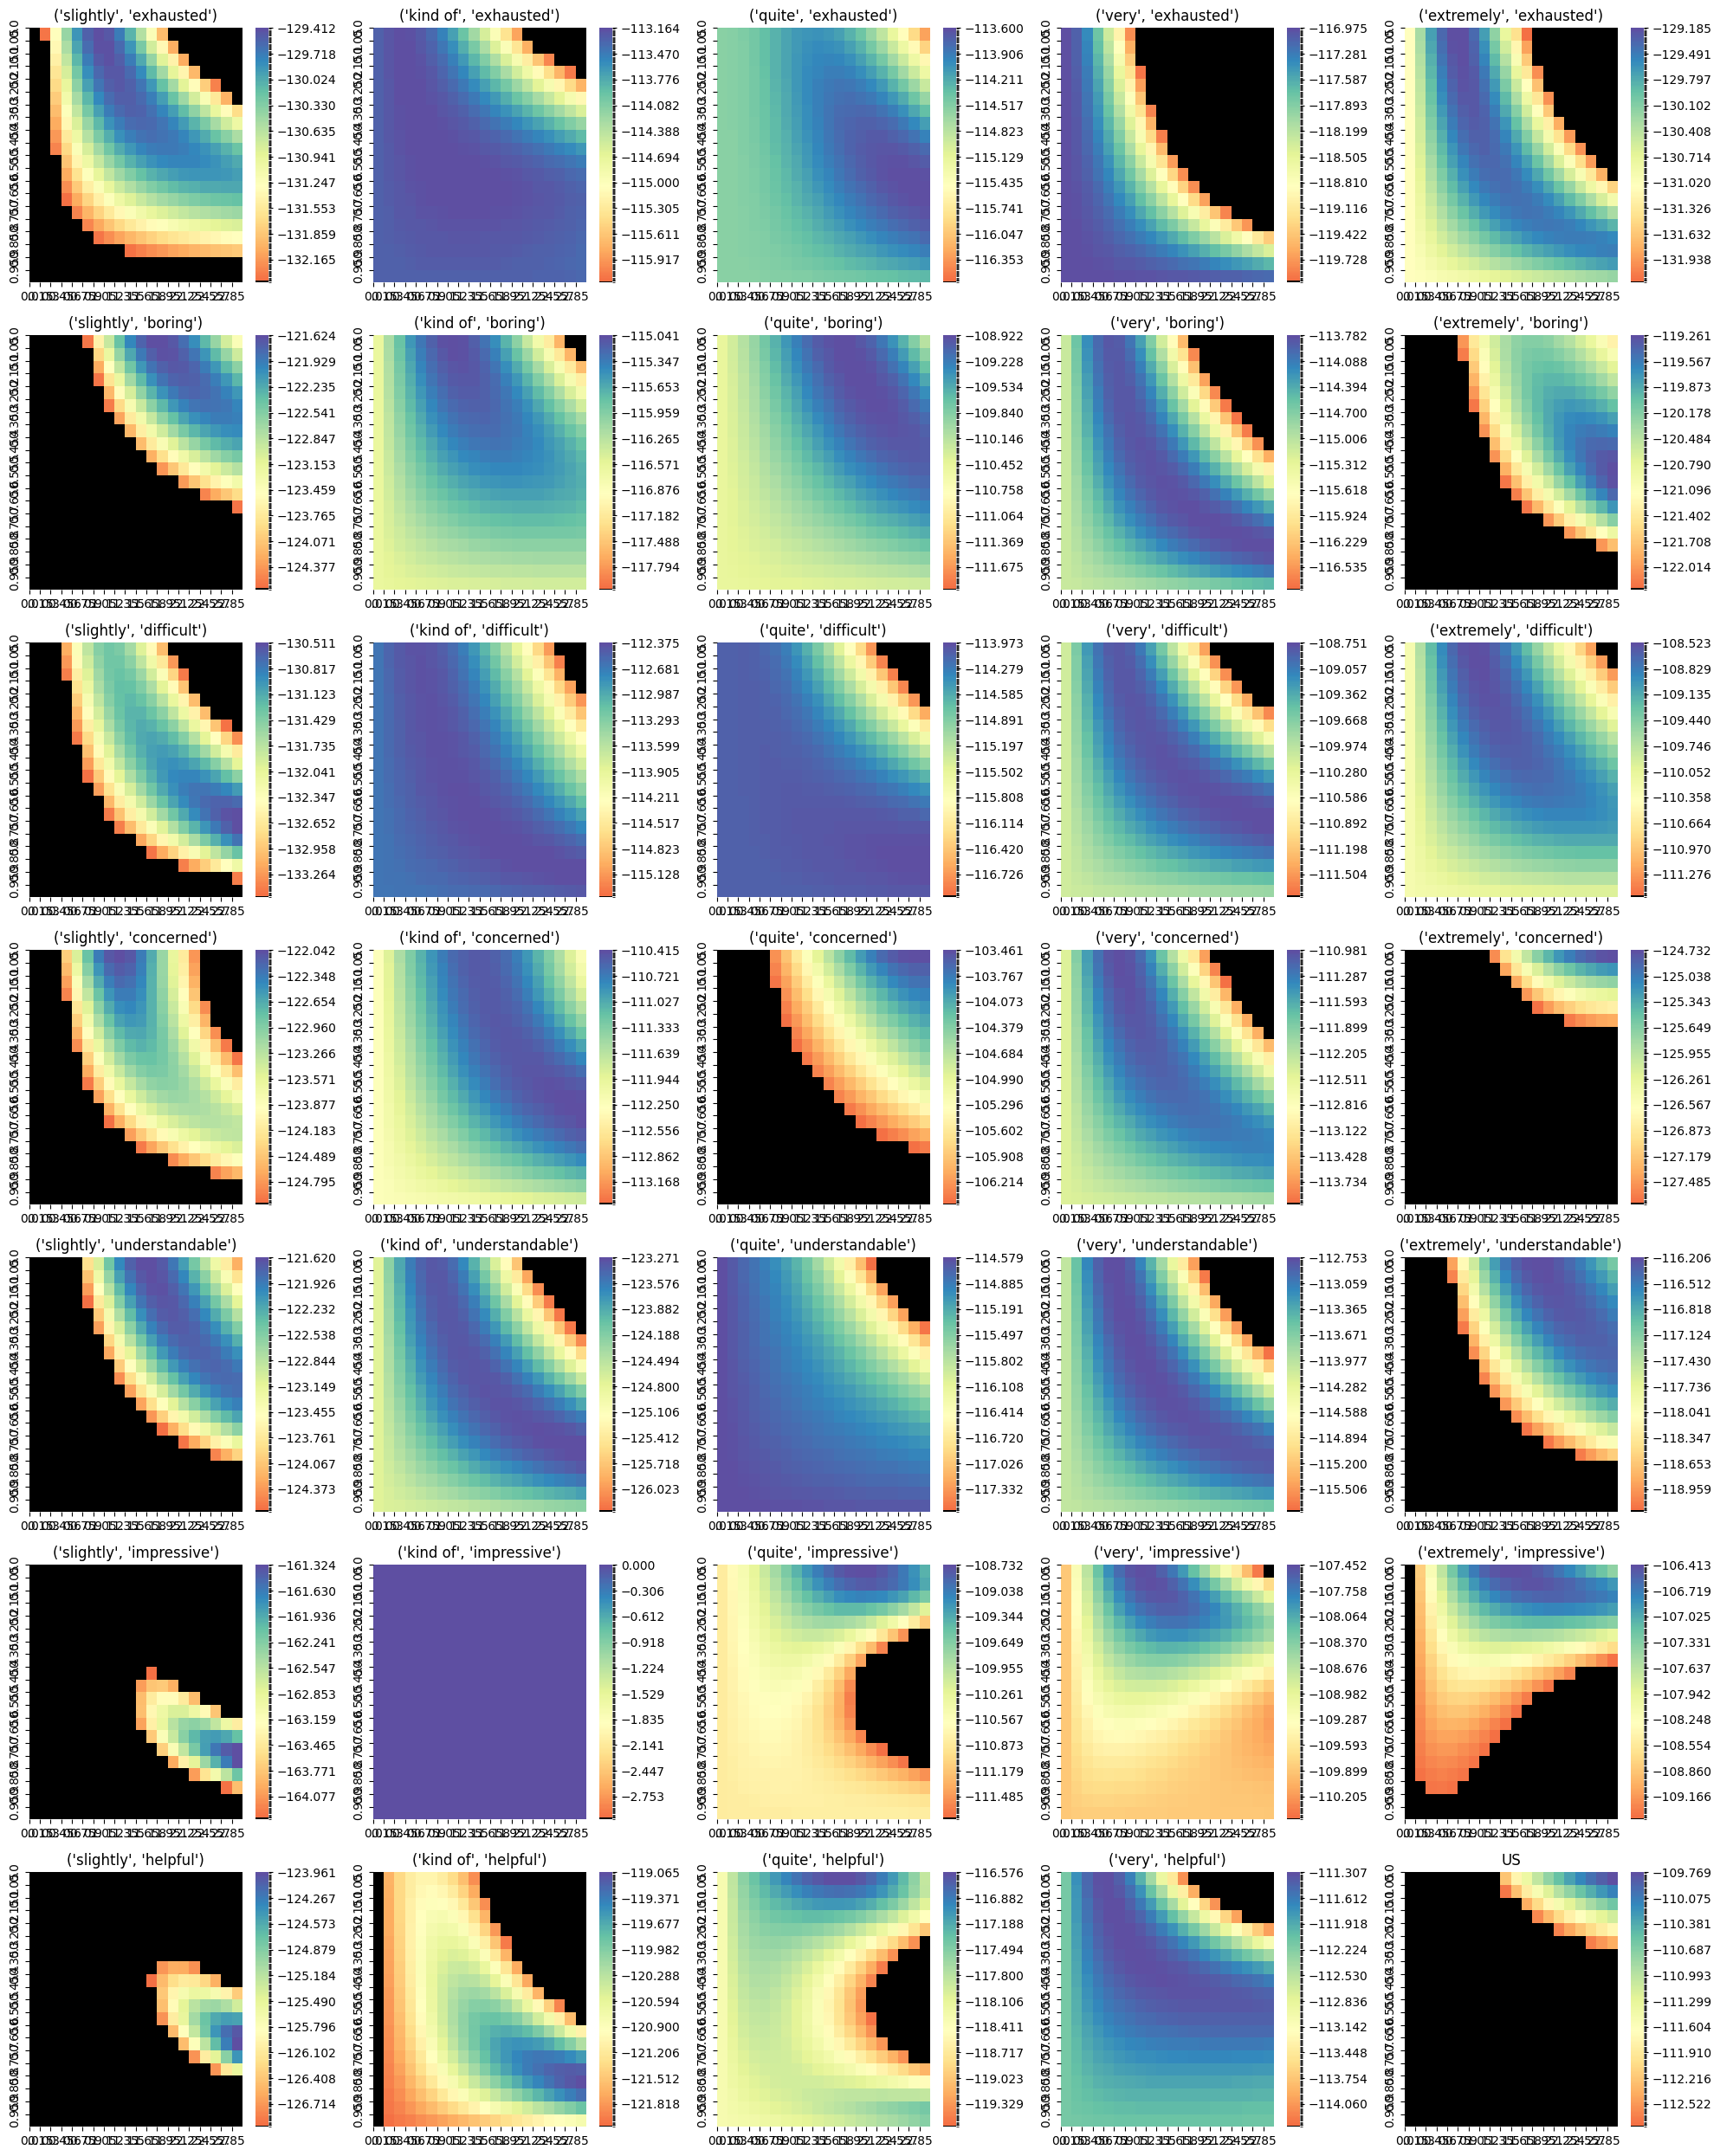

In [283]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
# Define a custom colormap
def plot_heatmap(data,title, possible_alpha, possible_phi):
    # Create a custom colormap that transitions from black to the base colormap
    base_cmap = sns.color_palette("Spectral", as_cmap=True)  # Base colormap
    colors = ["black"] + list(base_cmap(np.linspace(0.2, 1, 256)))  # Add black for below threshold
    custom_cmap = ListedColormap(colors)
    rows, cols = len(predicates),len(intensifiers)
    # Create subplots
    _, axes = plt.subplots(rows, cols, figsize=(20, 25))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        maximum = np.max(data[utterences[i]])
        bounds = [-10000, maximum-3] + list(np.linspace(maximum-3, maximum, 256))
        norm = BoundaryNorm(bounds, len(bounds) - 1)
        sns.heatmap(data[utterences[i]],ax=ax, cmap=custom_cmap, norm=norm, cbar=True)
        ax.set_title(f"{utterences[i]}")
        # label x and y by the possible values
        ax.set_xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
        ax.set_yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
        # rotate y ticks by 90
        ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.title(title)
    # Show the plots
    plt.show()
plot_heatmap(new_UK_fit_judgement,'UK',possible_alpha,possible_phi)
plot_heatmap(new_US_fit_judgement,'US',possible_alpha,possible_phi)


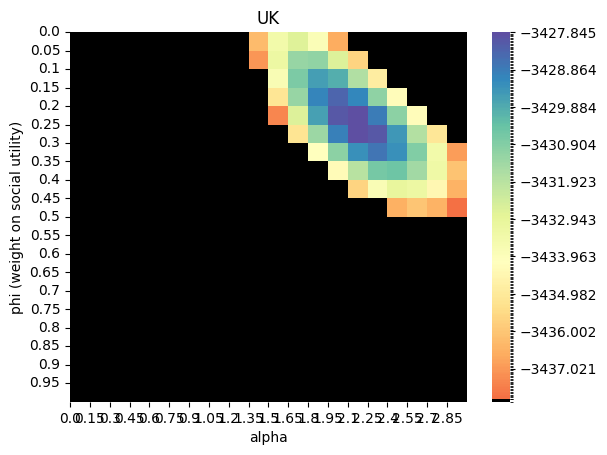

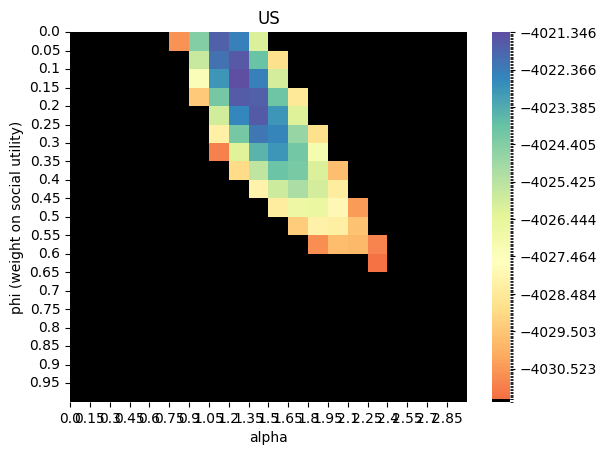

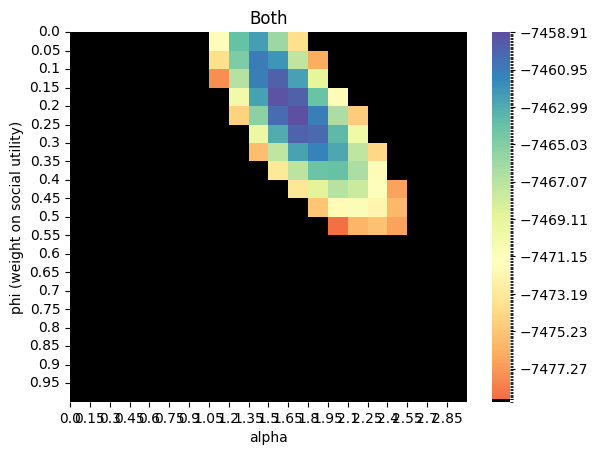

US best fit: (2, 8)
UK best fit: (4, 14)
best fit: (4, 11)


In [265]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
# Define a custom colormap
base_cmap = sns.color_palette("Spectral", as_cmap=True)  # Base colormap
colors = ["black"] + list(base_cmap(np.linspace(0.2, 1, 256)))  # Add black for below threshold
custom_cmap = ListedColormap(colors)

def plot_fits(fit_judgement, possible_alpha, possible_phi,title,minus_thresh):
    # Define a normalization function
    threshold = np.max(np.sum([fit_judgement[w] for w in utterences],axis=0))+minus_thresh
    bounds = [-10000, threshold] + list(np.linspace(threshold, np.max(np.sum([fit_judgement[w] for w in utterences],axis=0)), 256))
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    sns.heatmap(np.sum([fit_judgement[w] for w in utterences],axis=0), cmap=custom_cmap, norm=norm, cbar=True)# label x and y by the possible values
    plt.xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
    plt.yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
    # label x and y axis
    plt.xlabel('alpha')
    plt.ylabel('phi (weight on social utility)')
    # rotate y ticks by 90
    plt.yticks(rotation=0)
    # label colors in heatmap
    plt.title(title)
    # plt.colorbar()
    plt.show()
plot_fits(new_UK_fit_judgement,possible_alpha,possible_phi,'UK',-10)
plot_fits(new_US_fit_judgement,possible_alpha,possible_phi,'US',-10)
# plot both
plot_fits(new_fit_judgement,possible_alpha,possible_phi,'Both',-20)
# print best fit for US and UK
print(f"US best fit: {np.unravel_index(np.argmax(np.sum([new_US_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([new_US_fit_judgement[w] for w in utterences],axis=0).shape)}")
print(f"UK best fit: {np.unravel_index(np.argmax(np.sum([new_UK_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([new_UK_fit_judgement[w] for w in utterences],axis=0).shape)}")
print(f"best fit: {np.unravel_index(np.argmax(np.sum([new_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([new_fit_judgement[w] for w in utterences],axis=0).shape)}")

# Using theta for obtaining U_inf function

Define $U_{inf}$ by first defining $P_{L_0}$(s|w) using threshold function

In [ ]:
from scipy.optimize import minimize
states = np.arange(-6, 5.05, 0.05)
new_U_inf = dict()
possible_phi = np.arange(0,1,0.1)
possible_alpha = np.arange(0,3,0.3)
S = min(states)
theta_to_test = np.arrange(-4,-2.4,0.2)+np.arrange(-2.4,1.4,0.1)+np.arrange(1.4,3,0.2)
def theta_U_s1(w,s,phi,U_inf):
    # corresponds to U_s1(w) in the paper
    return phi*U_soc[w] + (1-phi)*U_inf[w[0]][int((s-S)*20)]
def theta_P_s1(alpha,phi,s,pred,U_inf):
    # corresponds to P_S1(w|s,phi)
    return softmax([ alpha*theta_U_s1((w,pred),s,phi,U_inf) for w in intensifiers])
def P_state(s):
    # return gaussian with mean 0 std 1
    return (1/np.sqrt(2*np.pi))*np.exp(-((s-0)**2)/(2*1**2))
# Define the function to minimize
import numpy as np
utterences =list(U_soc.keys())
predicates = list(set(w[1] for w in utterences))
intensifiers = list(set(w[0] for w in utterences))
new_P_s1 = dict() # corresponds to P_S1(w|s,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for s in states:
            # marginalized over all utterences with same predicate ('slightly' 'kind of' 'quite' 'very' 'extremely')
            for pred in predicates:
                new_P_s1[(alpha,phi,s,pred)] = softmax([ alpha*new_U_s1((w,pred),s,phi) for w in intensifiers])
# only thing left is computing P_l1
new_P_l1 = dict()# corresponds to P_L1(s|w,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for i in range(len(intensifiers)):
            for pred in predicates:
                w = intensifiers[i]
                new_P_l1[(alpha,phi,(w,pred))] = [new_P_s1[(alpha,phi,s,pred)][i]*P_state(s) for s in states]
                # normalize so adds up to 1
                new_P_l1[(alpha,phi,(w,pred))] = new_P_l1[(alpha,phi,(w,pred))]/np.sum(new_P_l1[(alpha,phi,(w,pred))])
epsilon = 0.01
theta_U_inf = dict()
P_l1 = dict()
for i in range(len(intensifiers)):
    theta_U_inf[intensifiers[i]] = np.array([epsilon if s <= thetas[i] else 1 for s in states])
    theta_U_inf[intensifiers[i]] = theta_U_inf[intensifiers[i]]/sum(theta_U_inf[intensifiers[i]])
    theta_U_inf[intensifiers[i]] = np.log(theta_U_inf[intensifiers[i]])
for pred in predicates:
    P_grid = []
    for s in states:
        P_grid.append(theta_P_s1(alpha,phi,s,pred,theta_U_inf))
    # swap rows and columns of P_grid
    P_grid = np.array(P_grid).T
    for i in range(len(intensifiers)):
        w = intensifiers[i]
        P_l1[(w,pred)] = P_grid[i]
        # normalize so adds up to 1
        P_l1[(w,pred)] = P_l1[(w,pred)]/np.sum(P_l1[(w,pred)])
log_likelihood = 0
for w in intensifiers:   
    for pred in predicates:
        measured_values = dialogue[((dialogue['intensifier'] == w) & (dialogue['predicate'] == pred))]['Z-Score Difference'].values
        log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*20)]) for s in measured_values)
print("Optimal Parameters:", result.x)
print("Minimum Value:", result.fun)

[(-6, 6), (-6, 6), (-6, 6), (-6, 6), (-6, 6), (0, 3), (0, 1)]


C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\561946634.py:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*20)]) for s in measured_values)


-8915.910826728945
-13415.819723697998
-10630.715673937228
-10985.914135979905
-10880.459704263018
-9442.094189241556
-10865.556616906297
-9827.307033067105
-9007.784078630642
-9916.09768603545
-9198.923724142303
-8915.910826728945
-9186.8147639471
-8915.910826728945
-8915.910826728945
-8915.910826728945
-8915.910826728945
-8915.910826728945
-8915.910826728945
-8915.910826728945
-8915.910826728945
-8915.910826728945
-8915.910826728945
-8915.910826728945
-8915.910826728945
-8915.910826728945
-13188.758197432377
-9143.970770276488
-9212.62200252443
-9181.814408843544
-9086.845225595656
-11298.381990290372
-9150.667489947029
-8940.347505721913
-10202.948936277044
-8951.135413819993
-8939.61202474851
-8939.61202474851
-8939.61202474851
-8939.61202474851
-8939.61202474851
-8939.61202474851
-8939.61202474851
-8939.61202474851
-8939.61202474851
-8939.61202474851
-8939.61202474851
-8939.61202474851
-12712.626224801623
-9432.178538907086
-10202.19536608354
-9627.15410451985
-8171.1947175834275


In [ ]:
print(intensifiers)

['very', 'slightly', 'extremely', 'quite', 'kind of']


Successfully doing parameter search

In [ ]:
from scipy.optimize import minimize
states = np.arange(-6, 5.05, 0.05)
S = min(states)
def theta_U_s1(w,s,phi,U_inf):
    # corresponds to U_s1(w) in the paper
    return phi*U_soc[w] + (1-phi)*U_inf[w[0]][int((s-S)*20)]
def theta_P_s1(alpha,phi,s,pred,U_inf):
    # corresponds to P_S1(w|s,phi)
    return softmax([ alpha*theta_U_s1((w,pred),s,phi,U_inf) for w in intensifiers])
def P_state(s):
    # return gaussian with mean 0 std 1
    return (1/np.sqrt(2*np.pi))*np.exp(-((s-0)**2)/(2*1**2))
# Define the function to minimize
def func_to_minimize(params):
    thetas = params[:5]
    alpha = params[5]
    phi = params[6]
    epsilon = 0.1
    theta_U_inf = dict()
    P_l1 = dict()
    for i in range(len(intensifiers)):
        theta_U_inf[intensifiers[i]] = np.array([epsilon if s <= thetas[i] else 1 for s in states])
        theta_U_inf[intensifiers[i]] = theta_U_inf[intensifiers[i]]/sum(theta_U_inf[intensifiers[i]])
        theta_U_inf[intensifiers[i]] = np.log(theta_U_inf[intensifiers[i]])
    for pred in predicates:
        P_grid = []
        for s in states:
            P_grid.append(theta_P_s1(alpha,phi,s,pred,theta_U_inf)*P_state(s))
        # swap rows and columns of P_grid
        P_grid = np.array(P_grid).T
        for i in range(len(intensifiers)):
            w = intensifiers[i]
            P_l1[(w,pred)] = P_grid[i]
            # normalize so adds up to 1
            P_l1[(w,pred)] = P_l1[(w,pred)]/np.sum(P_l1[(w,pred)])
    log_likelihood = 0
    for w in intensifiers:   
        for pred in predicates:
            measured_values = dialogue[((dialogue['intensifier'] == w) & (dialogue['predicate'] == pred))]['Z-Score Difference'].values
            log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*20)]) for s in measured_values)
    print(log_likelihood)
    return -log_likelihood

# Initial guess
initial_guess = [1,0,2,0,0, 1.5,0]

# Define bounds for each parameter
bounds = [(-6, 5)] * 5 + [(0,3),(0,1)] # 5 parameters, each ranging from -6 to 6
print(bounds)
# Run the optimization
result = minimize(func_to_minimize, initial_guess, method='Powell', bounds=bounds)

print("Optimal Parameters:", result.x)
print("Minimum Value:", result.fun)

[(-6, 6), (-6, 6), (-6, 6), (-6, 6), (-6, 6), (0, 3), (0, 1)]
-8622.467860774292


C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\2103104667.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*20)]) for s in measured_values)


-8684.46441647166
-8681.664892344303
-8728.967245488784
-8327.171362902096
-8304.22210648916
-8609.928080090218
-8430.952325360033
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8304.22210648916
-8643.017884797768
-8218.845288652497
-8183.254578449196
-8183.219008379823
-8184.062065803067
-8184.748581616197
-8185.175476639596
-8182.462949502073
-8185.579141137372
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8182.462949502073
-8197.502354446582
-8068.985617125978
-8237.294980162907
-7903.879696031095
-7770.861345919689
-8063.6615366318665
-7806.92723535841
-7896.2454414739805
-7762.813360901411
-7742.62

#### Record of results

Powell: 
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  0.54513784
  0.55593692]
Minimum Value: 7622.654024849191

SLSQP
Optimal Parameters: [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 5.24671918e-07 9.99998698e-01]
Minimum Value: 7773.548644439374

TNC:
Optimal Parameters: [0.         0.         1.         0.         0.         0.91291945, 1. ]
Minimum Value: 7773.548644439286

Nelder Mead:
Optimal Parameters: [ 0.0024747   0.0012909  -0.02271048  0.00263152  0.0018991   0.
  0.24250486]
Minimum Value: 7773.548644439286

trust-constr:
Optimal Parameters: [ 4.34396946e-08 -8.31980725e-09  1.00920297e+00  4.51582456e-08
  2.95320479e-08  1.54234285e+00  9.99406654e-01]
Minimum Value: 7773.710851762306

CG (starting from Powell):
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  0.91090539
  0.73335056]
Minimum Value: 7618.458113423883

BFGS
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  0.91090698
  0.73335143]
Minimum Value: 7618.458113423529

if epsilon = 0.01
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  1.01912567
  0.63853247]
Minimum Value: 7617.177330681999

Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  1.1721982
  0.66993666]
Minimum Value: 3540.0624957110535

UK - powell
Optimal Parameters: [-0.74820619  3.29998798 -0.35618854 -1.42530311 -1.30979051  0.71469205
  0.15471767]
Minimum Value: 3486.965957556221
US - Powell
Optimal Parameters: [-1.33231743  3.69999889 -0.90685264 -1.37751888 -1.96941291  0.66226507
  0.05043027]
Minimum Value: 4047.0662567772947

US - CG
Optimal Parameters: [-1.         -1.          0.         -1.         -2.          0.14551575
 -0.01626904]
Minimum Value: 4141.407529004872

all - CG (eps=0.01)
Optimal Parameters: [-1.         -1.          0.         -1.         -2.          5.76009058
  0.98151698]
Minimum Value: 7760.495904387104

all - powell (eps = 0.05)
Optimal Parameters: [-0.92819993  3.15148861 -0.46783021 -1.42192592 -1.64916572  0.86230122
  0.02336677]
Minimum Value: 7555.227659795885

all - powell (eps = 0.1)
Optimal Parameters: [-0.93643047  3.06772275 -0.46583885 -1.44719902 -1.46653402  1.13121295
  0.04682317]
Minimum Value: 7560.259834445015

In [ ]:
intensifiers

['very', 'slightly', 'extremely', 'quite', 'kind of']

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


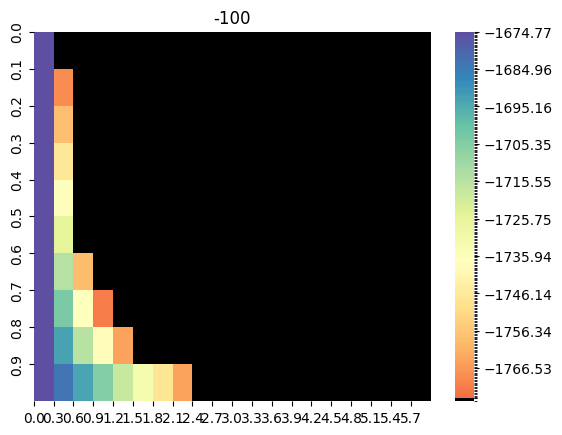

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


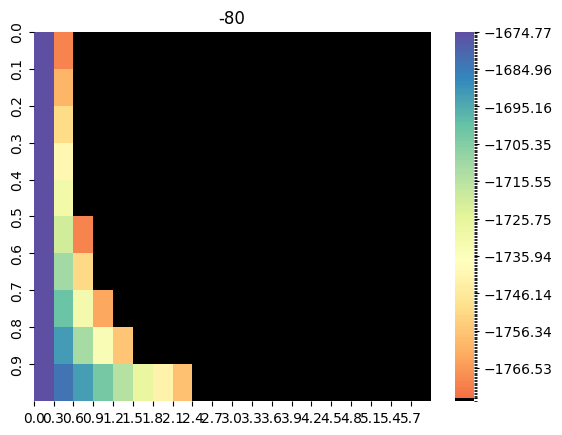

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


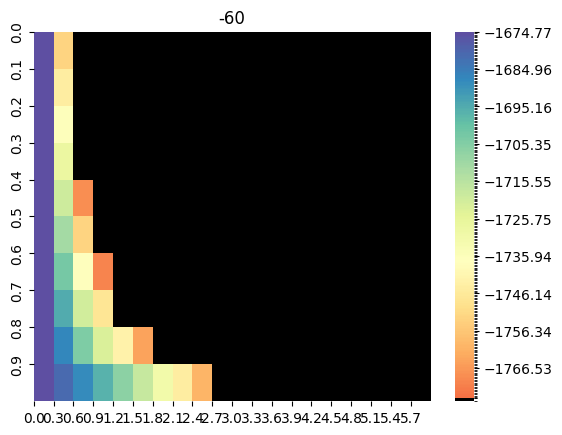

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


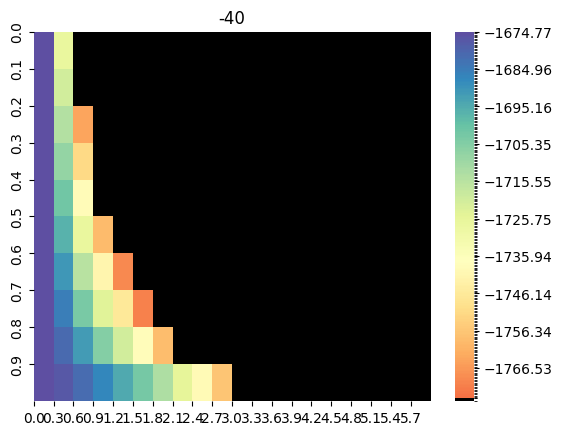

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


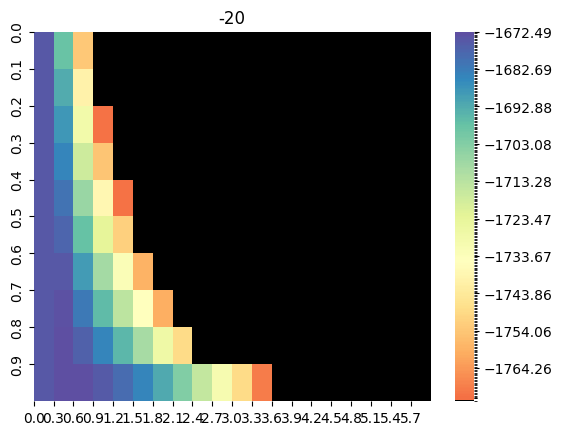

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


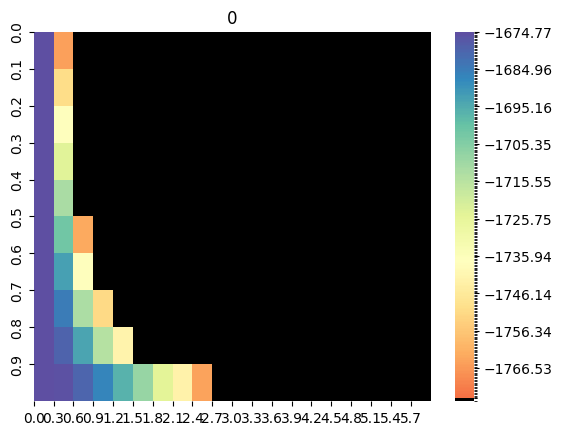

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


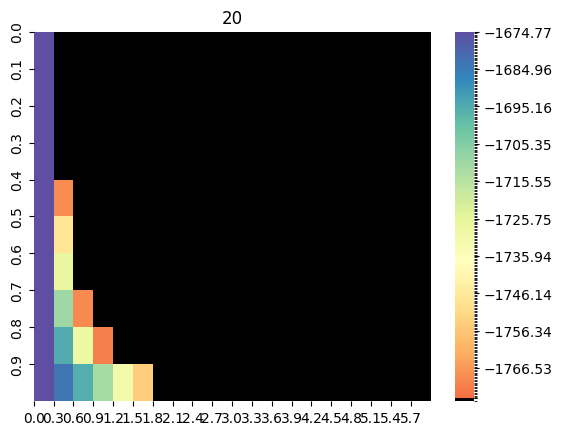

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


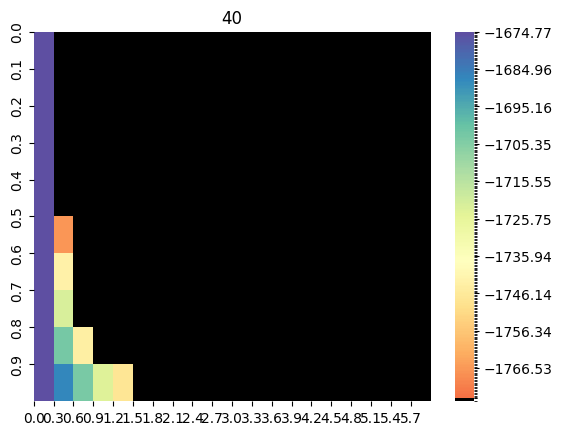

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


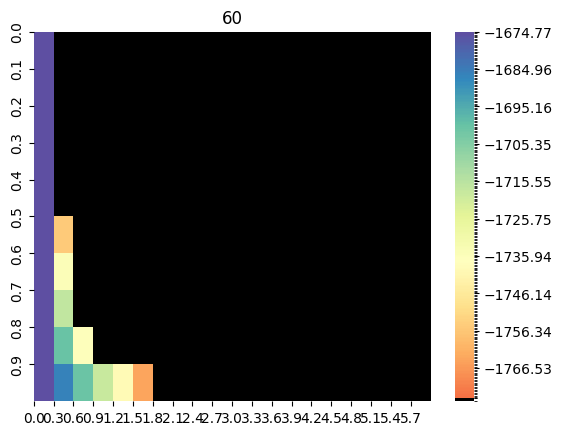

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


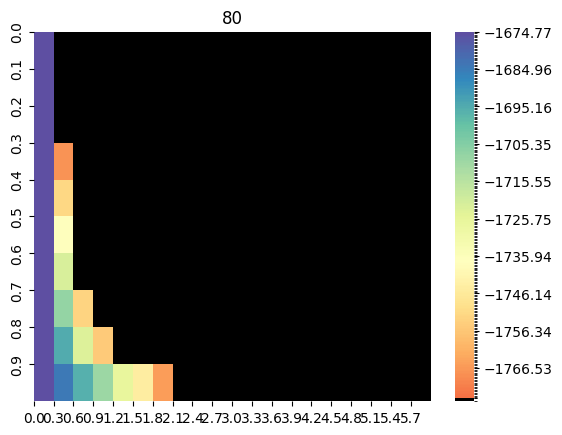

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


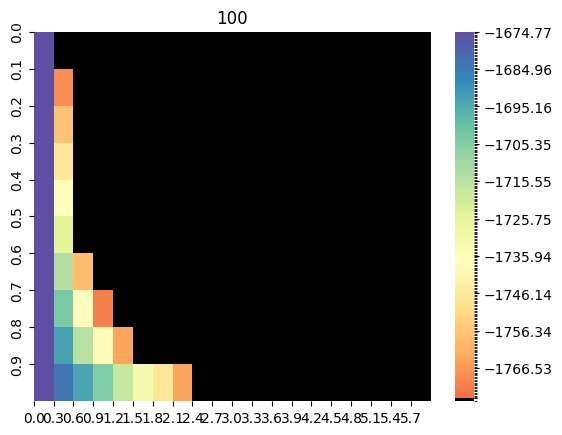

In [ ]:
def new_U_s1(w,s,phi,thresh):
    # corresponds to U_s1(w) in the paper
    return phi*U_soc[w] + (1-phi)*new_U_inf[(w[0],thresh)][s+100]
# s spans from -100 to 100
inten = 'extremely'
for thresh in [-100,-80,-60,-40,-20,0,20,40,60,80,100]:
    new_P_s1 = dict() # corresponds to P_S1(w|s,phi)
    for alpha in possible_alpha:
        for phi in possible_phi:
            for s in states:
                # marginalized over all utterences with same predicate ('slightly' 'kind of' 'quite' 'very' 'extremely')
                for pred in predicates:
                    new_P_s1[(alpha,phi,s,pred)] = softmax([ alpha*new_U_s1((w,pred),s,phi,thresh) if w == inten else alpha*U_s1((w,pred),s,phi)for w in intensifiers])
    # only thing left is computing P_l1
    new_P_l1 = dict()# corresponds to P_L1(s|w,phi)
    for alpha in possible_alpha:
        for phi in possible_phi:
            for pred in predicates:
                i = intensifiers.index(inten)
                w = intensifiers[i]
                P_l1[(alpha,phi,(w,pred))] = [new_P_s1[(alpha,phi,s,pred)][i]*P_state(s) for s in states]
                # normalize so adds up to 1
                P_l1[(alpha,phi,(w,pred))] = P_l1[(alpha,phi,(w,pred))]/np.sum(P_l1[(alpha,phi,(w,pred))])
    fit_judgement=dict()    
    for pred in predicates:
        fit_judgement[pred] = np.zeros((len(possible_phi),len(possible_alpha)))
        measured_values = dialogue[((dialogue['intensifier'] == inten) & (dialogue['predicate'] == pred))]['difference'].values
        for i in range(len(possible_phi)):
            for j in range(len(possible_alpha)):
                fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)
    threshold = np.max(np.sum([fit_judgement[pred] for pred in predicates],axis=0))-100
    bounds = [-10000, threshold] + list(np.linspace(threshold, np.max(np.sum([fit_judgement[pred] for pred in predicates],axis=0)), 256))
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    sns.heatmap(np.sum([fit_judgement[pred] for pred in predicates],axis=0), cmap=custom_cmap,norm=norm, cbar=True)
    # label x and y by the possible values
    plt.xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
    plt.yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
    # label colors in heatmap
    plt.title(f'{thresh}')
    plt.show()
    
                
